###Implementação 2

In [ ]:
# %%
# Utilities for representing the instance, verifying a candidate sequence,
# and plotting (1) a Gantt chart of the scheduled solution and
# (2) a precedence graph with durations and precedence delays.
#
# Notes for plotting with ChatGPT Python tool:
# - Use matplotlib (no seaborn).
# - Each chart has its own figure (no subplots).
# - Do not set specific colors; rely on defaults.


from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import math

import matplotlib.pyplot as plt


# ---------------------------
# 1) Problem representation
# ---------------------------

@dataclass
class Instance:
    """
    Instância 1 | s_ij, prec(d_ij) | C_max
    - n: número de jobs reais (1..n). Também usamos 0 (início) e n+1 (fim) como dummies.
    - p: tempos de processamento, indexados 0..n+1 (p[0]=p[n+1]=0).
    - s: matriz (n+2)x(n+2) de setups s[i][j], incluindo 0 e n+1 (convenção: s[i][i]=0).
    - A: lista de pares (i, j) com precedência atrasada (i deve preceder j).
    - d: dicionário d[(i,j)] = atraso d_ij, apenas para (i,j) em A.
    """
    n: int
    p: List[float]
    s: List[List[float]]
    A: List[Tuple[int, int]]
    d: Dict[Tuple[int, int], float]

    def check_basic_shapes(self) -> None:
        assert len(self.p) == self.n + 2, "p deve ter índices 0..n+1 (com p[0]=p[n+1]=0)."
        assert len(self.s) == self.n + 2 and all(len(row) == self.n + 2 for row in self.s), \
            "s deve ser (n+2) x (n+2), incluindo 0 e n+1."
        assert self.p[0] == 0 and self.p[self.n+1] == 0, "Use p[0]=p[n+1]=0 para os dummies."
        for i in range(self.n + 2):
            assert self.s[i][i] == 0, "Convencione s[i][i]=0."
        for (i, j) in self.A:
            assert (i, j) in self.d, f"Falta d[(i,{j})] para precedência declarada."


def load_instance_from_txt(file_path: str) -> Instance:
    """
    Carrega uma instância do problema a partir de um arquivo .txt.
    O arquivo deve estar no formato que foi fornecido (R, Pj, A, Sij).
    """
    with open(file_path, 'r') as f:
        # Lendo o número de jobs
        R = int(f.readline().strip())

        # Lendo o vetor de tempos de processamento Pj
        Pj = list(map(int, f.readline().strip().split(',')))

        # Lendo a matriz de precedências atrasadas A
        A = []
        while True:
            line = f.readline().strip()
            if line == '':  # Fim da seção de A
                break
            i, j, d_ij = map(int, line.split(','))
            A.append((i, j, d_ij))

        # Lendo a matriz de setups Sij
        Sij = []
        for i in range(R):
            line = list(map(int, f.readline().strip().split(',')))
            Sij.append(line)

    # Criando a instância no formato correto
    inst = Instance(
        n=R,                  # número de jobs reais
        p=[0] + Pj + [0],     # p[0] e p[n+1] são 0
        s=[[0]* (R+2)] + [[0] + row + [0] for row in Sij] + [[0]*(R+2)],  # s[i][j] com setup entre todos os jobs
        A=[(i, j) for (i, j, _) in A],  # Ignorando o atraso no momento da leitura
        d={(i, j): delay for (i, j, delay) in A}  # d_ij para cada par de precedência
    )

    return inst

# ---------------------------
# 2) Verificador e agenda
# ---------------------------

def verify_solution(inst: Instance, seq: List[int]) -> Dict:
    """
    Verifica se 'seq' é uma solução válida e calcula:
      - feasible: bool
      - violations: lista textual com violações (se houver)
      - C_max: makespan
      - b, c: listas com inícios e términos
      - sequence_normalized: sequência incluindo 0 e n+1
    A sequência pode ser:
      - apenas jobs reais [perm de 1..n], ou
      - já incluindo [0, ..., n+1].
    """
    inst.check_basic_shapes()
    n = inst.n
    jobs_real = set(range(1, n+1))

    # Normaliza para conter 0 e n+1
    seq_norm = seq[:]
    if len(seq_norm) == n and set(seq_norm) == jobs_real:
        seq_norm = [0] + seq_norm + [n+1]
    else:
        if set(seq_norm) != (jobs_real | {0, n+1}):
            return {"feasible": False, "violations": ["Sequência deve ter exatamente jobs 0,1..n,n+1."],
                    "C_max": None, "b": None, "c": None, "sequence_normalized": seq_norm}
        if seq_norm[0] != 0 or seq_norm[-1] != n+1:
            return {"feasible": False, "violations": ["Sequência deve iniciar em 0 e terminar em n+1."],
                    "C_max": None, "b": None, "c": None, "sequence_normalized": seq_norm}

    # Cada job real aparece uma vez
    seen = [x for x in seq_norm if x not in (0, n+1)]
    if len(seen) != n or set(seen) != jobs_real:
        return {"feasible": False, "violations": ["Cada job real 1..n deve aparecer exatamente uma vez."],
                "C_max": None, "b": None, "c": None, "sequence_normalized": seq_norm}

    # Precedência estrutural
    pos = {job: idx for idx, job in enumerate(seq_norm)}
    order_viol = []
    for (i, j) in inst.A:
        if pos.get(i, -1) >= 0 and pos.get(j, -1) >= 0:
            if pos[i] > pos[j]:
                order_viol.append((i, j))
    if order_viol:
        return {"feasible": False, "violations": [f"Ordem de precedência violada (i antes de j): {order_viol}."],
                "C_max": None, "b": None, "c": None, "sequence_normalized": seq_norm}

    # Agenda: b e c; releases por atrasos: es
    b = [0.0] * (n + 2)
    c = [0.0] * (n + 2)
    es = [0.0] * (n + 2)

    c[0] = b[0] + inst.p[0]  # 0

    violations = []

    # Varre pares consecutivos
    for r in range(1, len(seq_norm)):
        i = seq_norm[r-1]
        j = seq_norm[r]
        # Respeita setup imediato i->j e release acumulado es[j]
        cand_setup = c[i] + inst.s[i][j]
        b[j] = max(b[j], cand_setup, es[j])
        c[j] = b[j] + inst.p[j]
        # Propaga releases para sucessores de j
        for (a, bsucc) in inst.A:
            if a == j:
                es[bsucc] = max(es[bsucc], c[j] + inst.d[(a, bsucc)])

    # Checagens explícitas
    for r in range(1, len(seq_norm)):
        i = seq_norm[r-1]; j = seq_norm[r]
        if b[j] < c[i] + inst.s[i][j] - 1e-9:
            violations.append(f"(7) violada em {i}->{j}: b[{j}]={b[j]} < c[{i}]={c[i]} + s[{i},{j}]={inst.s[i][j]}")
    for (i, j) in inst.A:
        if b[j] < c[i] + inst.d[(i, j)] - 1e-9:
            violations.append(f"(8) violada: b[{j}]={b[j]} < c[{i}]={c[i]} + d[{i},{j}]={inst.d[(i,j)]}")

    feasible = len(violations) == 0
    C_max = max(c[1:n+1]) if feasible else None

    return {"feasible": feasible, "violations": violations, "C_max": C_max, "b": b, "c": c, "sequence_normalized": seq_norm}


# ---------------------------
# 3) Plot: Gantt da solução
# ---------------------------

def plot_gantt(inst: Instance, res: Dict, title: Optional[str] = None) -> None:
    """
    Plota um Gantt simples da solução.
    - Barras para os jobs reais (1..n) em ordem de execução na sequência normalizada.
    - Cada barra mostra [b[i], c[i]] (apenas processamento).
    - Linhas verticais finas marcam b[i] e c[i].
    - Pequenas setas entre pares consecutivos indicam a transição (setup implícito no gap).
    """
    if not res.get("feasible", False):
        print("Solução não é factível. Violações:", res.get("violations"))
        return
    seq = res["sequence_normalized"]
    b = res["b"]
    c = res["c"]

    # Apenas jobs reais (exclui dummies)
    exec_order = [j for j in seq if j not in (0, inst.n+1)]

    # Figura única (sem subplots)
    plt.figure(figsize=(10, max(3, len(exec_order) * 0.5)))
    yticks = []
    ylabels = []

    for idx, j in enumerate(exec_order):
        y = idx
        yticks.append(y)
        ylabels.append(f"Job {j}")
        start = b[j]
        duration = inst.p[j]
        # Barra horizontal de processamento
        plt.barh(y, duration, left=start, height=0.4)
        # Marcas de início e fim
        plt.vlines(start, y-0.2, y+0.2, linewidth=1)
        plt.vlines(c[j], y-0.2, y+0.2, linewidth=1)
        # Texto com [b,c]
        plt.text((start + c[j]) / 2, y, f"[{start:.1f}, {c[j]:.1f}]", ha="center", va="center")

    # Setas entre consecutivos (indica transições)
    for r in range(1, len(exec_order)):
        i = exec_order[r-1]
        j = exec_order[r]
        plt.annotate("",
                     xy=(b[j], r), xycoords='data',
                     xytext=(c[i], r-1), textcoords='data',
                     arrowprops=dict(arrowstyle="->", lw=1))

    plt.yticks(yticks, ylabels)
    plt.xlabel("Tempo")
    if title is None:
        title = f"Gantt da solução — C_max = {res['C_max']:.1f}"
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------
# 4) Plot: Grafo de precedência (dur. e atrasos)
# ----------------------------------------------

def plot_precedence_graph(inst: Instance, title: Optional[str] = None) -> None:
    """
    Desenha um grafo direcionado simples (sem networkx) para precedências.
    - Cada nó é um job real (1..n), com rótulo "j (p_j)".
    - Cada arco (i->j) em A tem rótulo "d_ij".
    - Layout por camadas: níveis topológicos simples calculados
      via Kahn (ignorando dummies 0 e n+1).
    """
    n = inst.n
    # Constrói DAG só com jobs reais
    succ = {i: [] for i in range(1, n+1)}
    indeg = {i: 0 for i in range(1, n+1)}
    for (i, j) in inst.A:
        if 1 <= i <= n and 1 <= j <= n:
            succ[i].append(j)
            indeg[j] += 1

    # Kahn para camadas
    layers: List[List[int]] = []
    current = [i for i in range(1, n+1) if indeg[i] == 0]
    visited = set()
    while current:
        layers.append(current[:])
        next_level = []
        for u in current:
            visited.add(u)
            for v in succ[u]:
                indeg[v] -= 1
                if indeg[v] == 0:
                    next_level.append(v)
        current = next_level

    # Se sobrou nó não visitado (ciclos): ainda vamos plotar, empilhando restante
    remaining = [i for i in range(1, n+1) if i not in visited]
    if remaining:
        layers.append(remaining)

    # Coordenadas dos nós
    positions: Dict[int, Tuple[float, float]] = {}
    x_gap = 3.0
    y_gap = 1.5
    for lx, level in enumerate(layers):
        for k, node in enumerate(level):
            positions[node] = (lx * x_gap, -k * y_gap)

    # Figura única (sem subplots)
    plt.figure(figsize=(max(6, 2*len(layers)), max(3, 0.5*n)))
    # Nós
    for node, (x, y) in positions.items():
        plt.scatter([x], [y], s=200)
        plt.text(x, y+0.2, f"{node} (p={inst.p[node]})", ha="center")

    # Arestas com rótulo d_ij
    for (i, j) in inst.A:
        if i in positions and j in positions:
            x1, y1 = positions[i]
            x2, y2 = positions[j]
            plt.annotate("",
                         xy=(x2, y2), xycoords='data',
                         xytext=(x1, y1), textcoords='data',
                         arrowprops=dict(arrowstyle="->", lw=1))
            # Rótulo próximo ao meio
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2
            dij = inst.d.get((i, j), None)
            lbl = f"d={dij}" if dij is not None else "d=?"
            plt.text(mx, my+0.2, lbl, ha="center")

    plt.axis("off")
    if title is None:
        title = "Precedências (rótulo do nó = job e p; rótulo da aresta = d_ij)"
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# ---------------------------
# 5) Demonstração rápida
# ---------------------------

# Exemplo usado anteriormente (ajustado para floats)
n = 3
p = [0.0, 5.0, 3.0, 4.0, 0.0]
s = [
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 2.0, 1.0, 0.0],
    [0.0, 2.0, 0.0, 3.0, 0.0],
    [0.0, 1.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
]
A = [(1, 2)]          # 1 precede 2 com atraso
d = {(1, 2): 4.0}

inst = Instance(n=n, p=p, s=s, A=A, d=d)

# Sequência candidata
seq = [1, 2, 3]
res = verify_solution(inst, seq)

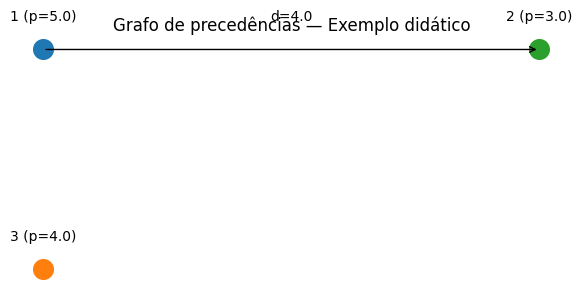

In [ ]:
plot_precedence_graph(inst, title="Grafo de precedências — Exemplo didático")

Sequência: [1, 2, 3]
Factível? True
C_max = 19.0
Violações: []
b (inícios): [0.0, 0.0, 9.0, 15.0, 19.0]
c (términos): [0.0, 5.0, 12.0, 19.0, 19.0]
Sequência normalizada: [0, 1, 2, 3, 4]


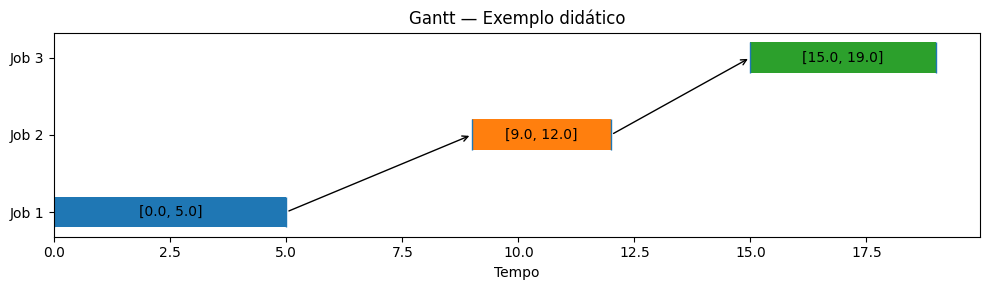

************************************

Sequência: [1, 3, 2]
Factível? True
C_max = 14.0
Violações: []
b (inícios): [0.0, 0.0, 11.0, 6.0, 14.0]
c (términos): [0.0, 5.0, 14.0, 10.0, 14.0]
Sequência normalizada: [0, 1, 3, 2, 4]


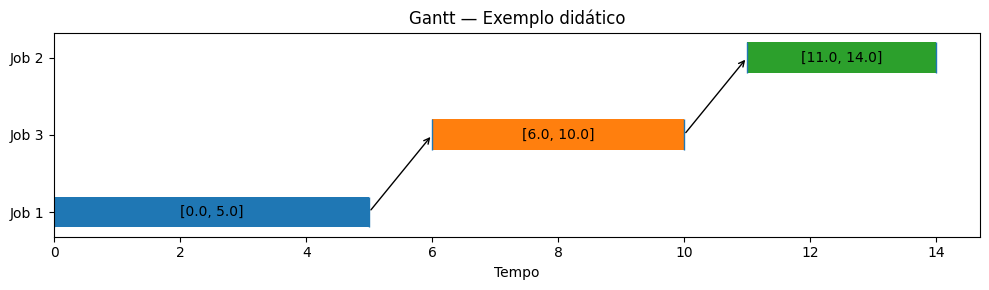

************************************

Sequência: [2, 1, 3]
Factível? False
C_max = None
Violações: ['Ordem de precedência violada (i antes de j): [(1, 2)].']
b (inícios): None
c (términos): None
Sequência normalizada: [0, 2, 1, 3, 4]
Solução não é factível. Violações: ['Ordem de precedência violada (i antes de j): [(1, 2)].']
************************************

Sequência: [2, 3, 1]
Factível? False
C_max = None
Violações: ['Ordem de precedência violada (i antes de j): [(1, 2)].']
b (inícios): None
c (términos): None
Sequência normalizada: [0, 2, 3, 1, 4]
Solução não é factível. Violações: ['Ordem de precedência violada (i antes de j): [(1, 2)].']
************************************

Sequência: [3, 1, 2]
Factível? True
C_max = 17.0
Violações: []
b (inícios): [0.0, 5.0, 14.0, 0.0, 17.0]
c (términos): [0.0, 10.0, 17.0, 4.0, 17.0]
Sequência normalizada: [0, 3, 1, 2, 4]


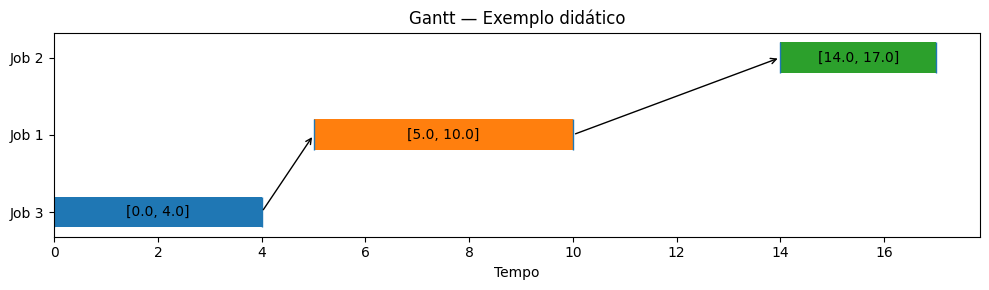

************************************

Sequência: [3, 2, 1]
Factível? False
C_max = None
Violações: ['Ordem de precedência violada (i antes de j): [(1, 2)].']
b (inícios): None
c (términos): None
Sequência normalizada: [0, 3, 2, 1, 4]
Solução não é factível. Violações: ['Ordem de precedência violada (i antes de j): [(1, 2)].']
************************************



In [ ]:
# Exemplo didático com n=3
n = 3
p = [0, 5, 3, 4, 0]              # p[0]=p[4]=0; jobs 1..3 reais
s = [[0,0,0,0,0],                # s[0][*] setups a partir do dummy inicial
     [0,0,2,1,0],
     [0,2,0,3,0],
     [0,1,1,0,0],
     [0,0,0,0,0]]                # s[*][4] setups para o dummy final (costume: zeros)
A = [(1,2)]                      # 1 deve preceder 2 com atraso d_12
d = {(1,2): 4}

inst = Instance(n=n, p=p, s=s, A=A, d=d)
seqs = [[1, 2, 3],
        [1, 3, 2],
        [2, 1, 3],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1]]

for seq in seqs:
  print(f"Sequência: {seq}")
  res = verify_solution(inst, seq)

  print("Factível?", res["feasible"])
  print("C_max =", res["C_max"])
  print("Violações:", res["violations"])
  print("b (inícios):", res["b"])
  print("c (términos):", res["c"])
  print("Sequência normalizada:", res["sequence_normalized"])
  # Plots
  plot_gantt(inst, res, title="Gantt — Exemplo didático")
  print("************************************\n")


##

##Implementação 3


In [9]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

# ---------------------------
# 1) Problema de Representação
# ---------------------------

@dataclass
class Instance:
    """
    Instância 1 | s_ij, prec(d_ij) | C_max
    - n: número de jobs reais (1..n). Também usamos 0 (início) e n+1 (fim) como dummies.
    - p: tempos de processamento, indexados 0..n+1 (p[0]=p[n+1]=0).
    - s: matriz (n+2)x(n+2) de setups s[i][j], incluindo 0 e n+1 (convenção: s[i][i]=0).
    - dij: matriz de atrasos de precedência (nxn), -1 se não houver precedência.
    """
    n: int
    p: List[float]
    s: List[List[float]]
    dij: List[List[float]]  # Matriz de atrasos de precedência (nxn)

    def check_basic_shapes(self) -> None:
        assert len(self.p) == self.n + 2, "p deve ter índices 0..n+1 (com p[0]=p[n+1]=0)."
        assert len(self.s) == self.n + 2 and all(len(row) == self.n + 2 for row in self.s), \
            "s deve ser (n+2) x (n+2), incluindo 0 e n+1."
        assert len(self.dij) == self.n + 2 and all(len(row) == self.n + 2 for row in self.dij), \
            "dij deve ser (n+2) x (n+2), incluindo 0 e n+1."
        assert self.p[0] == 0 and self.p[self.n+1] == 0, "Use p[0]=p[n+1]=0 para os dummies."
        for i in range(self.n + 2):
            assert self.s[i][i] == 0, "Convencione s[i][i]=0."
            assert all(self.dij[i][j] == -1 or self.dij[i][j] >= 0 for j in range(self.n + 2)), \
                "Valores de atraso devem ser >=0 ou -1."

# ---------------------------
# 2) Carregar instância do arquivo .txt
# ---------------------------

def load_instance_from_txt(file_path: str) -> Instance:
    """
    Carrega uma instância do problema a partir de um arquivo .txt.
    O arquivo deve estar no formato fornecido (R, Pj, A, Sij).
    """
    with open(file_path, 'r') as f:
        # Lendo o número de jobs (R) e removendo o prefixo "R="
        R_line = f.readline().strip()
        R = int(R_line.split('=')[1])
        
        # Lendo o vetor de tempos de processamento Pj (Pi=...)
        Pj_line = f.readline().strip()
        Pj = list(map(int, Pj_line.split('=')[1].strip('()').split(',')))
        
        # Lendo a matriz de precedências atrasadas A
        dij = [[-1 for _ in range(R+2)] for _ in range(R+2)]  # Matriz de atrasos (inicializa com -1)
        
        line = f.readline().strip()
        if line != 'A=':
            raise ValueError("Formato inválido: Esperado 'A=' após Pj.")
        while True:
            line = f.readline().strip()
            
            if line == 'Sij=':  # Fim da seção de A
                break
            i, j, d_ij = map(int, line.split(','))
            dij[i][j] = d_ij  # Preenche a matriz com o atraso de precedência
        
        # Lendo a matriz de setups Sij
        Sij = []
        for i in range(R):
            line = list(map(int, f.readline().strip().split(',')))
            Sij.append(line)
    
    # Criando a instância no formato correto
    inst = Instance(
        n=R,                  # número de jobs reais
        p=[0] + Pj + [0],     # p[0] e p[n+1] são 0
        s=[[0]* (R+2)] + [[0] + row + [0] for row in Sij] + [[0]*(R+2)],  # s[i][j] com setup entre todos os jobs
        dij=[[ -1 ] * (R+2)] + [[-1] + row + [-1] for row in dij[1:]] + [[-1]*(R+2)]  # Atrasos com -1 onde não há precedência
    )
    
    return inst



# ---------------------------
# 3) Verificar e calcular a solução
# ---------------------------

def verify_solution(inst: Instance, seq: List[int]) -> Dict:
    """
    Verifica se 'seq' é uma solução válida e calcula:
      - factível? (boolean)
      - violações (lista textual)
      - C_max (makespan)
      - cronograma: b[i], c[i] (inícios e términos)
      - sequence_normalized: sequência incluindo 0 e n+1
    Aceita seq como:
      (a) somente jobs reais [perm de 1..n], ou
      (b) já incluindo [0, ..., n+1]. Em ambos os casos, normalizamos para [0] + reais + [n+1].
    """
    inst.check_basic_shapes()

    n = inst.n
    jobs_real = set(range(1, n+1))

    # Normaliza sequência para conter 0 e n+1
    seq_norm = seq[:]
    if len(seq_norm) == n and set(seq_norm) == jobs_real:
        seq_norm = [0] + seq_norm + [n+1]
    else:
        # Se usuário passou com dummies, valide conteúdos e ordem das pontas
        if set(seq_norm) != (jobs_real | {0, n+1}):
            return {"feasible": False, "violations": ["Sequência deve ter exatamente jobs 0,1..n,n+1."],
                    "C_max": None, "b": None, "c": None}
        if seq_norm[0] != 0 or seq_norm[-1] != n+1:
            return {"feasible": False, "violations": ["Sequência deve iniciar em 0 e terminar em n+1."],
                    "C_max": None, "b": None, "c": None}

    # Checa precedência de ordem (i antes de j) — Eq. (8) estrutura (ordem)
    pos = {job: idx for idx, job in enumerate(seq_norm)}
    order_viol = []
    for i in range(1, n+1):
        for j in range(1, n+1):
            if inst.dij[i][j] != -1 and pos[i] > pos[j]:  # Caso haja precedência
                order_viol.append((i, j))
    if order_viol:
        return {"feasible": False, "violations": [f"Ordem de precedência violada: {order_viol}."],
                "C_max": None, "b": None, "c": None}

    # Agenda (b,c) seguindo a Seção 3 e Fig. 1:
    b = [0.0] * (n + 2)
    c = [0.0] * (n + 2)
    es = [0.0] * (n + 2)

    c[0] = b[0] + inst.p[0]  # 0

    violations = []

    # Varremos pares consecutivos para aplicar (7) e os es[j] de (8)
    for r in range(1, len(seq_norm)):  # r varre posição 1..n+1
        i = seq_norm[r-1]
        j = seq_norm[r]
        # Atualiza es[*] causados por terminar i e existir (i, k) ∈ A: es[k] = max(es[k], c[i] + d[i,k])
        for k in range(1, n+1):
            if inst.dij[i][k] != -1:  # Se há precedência entre i e k
                es[k] = max(es[k], c[i] + inst.dij[i][k])
        
        # Definir b[j] respeitando Eq. (7): b_j >= c_i + s_ij quando j sucede imediatamente i
        cand_setup = c[i] + inst.s[i][j]
        b[j] = max(b[j], cand_setup, es[j])
        
        # Agora computa término de j: Eq. (9)
        c[j] = b[j] + inst.p[j]

    # Checagens de viabilidade temporal (redundantes se a agenda foi construída corretamente)
    for r in range(1, len(seq_norm)):
        i = seq_norm[r-1]; j = seq_norm[r]
        if b[j] < c[i] + inst.s[i][j]:
            violations.append(f"(7) violada em {i}->{j}: b[{j}]={b[j]} < c[{i}]={c[i]} + s[{i},{j}]={inst.s[i][j]}")
    for i in range(1, n+1):
        for j in range(1, n+1):
            if inst.dij[i][j] != -1 and b[j] < c[i] + inst.dij[i][j]:
                violations.append(f"(8) violada: b[{j}]={b[j]} < c[{i}]={c[i]} + d[{i},{j}]={inst.dij[i][j]}")

    feasible = len(violations) == 0
    C_max = max(c[1:n+1]) if feasible else None

    return {"feasible": feasible, "violations": violations, "C_max": C_max, "b": b, "c": c, "sequence_normalized": seq_norm}

# ---------------------------
# 4) Plot: Gantt da solução
# ---------------------------

def plot_gantt(inst: Instance, res: Dict, title: Optional[str] = None) -> None:
    """
    Plota um Gantt simples da solução.
    """
    if not res.get("feasible", False):
        print("Solução não é factível. Violações:", res.get("violations"))
        return
    seq = res["sequence_normalized"]
    b = res["b"]
    c = res["c"]

    # Apenas jobs reais (exclui dummies)
    exec_order = [j for j in seq if j not in (0, inst.n+1)]

    plt.figure(figsize=(10, max(3, len(exec_order) * 0.5)))
    yticks = []
    ylabels = []

    for idx, j in enumerate(exec_order):
        y = idx
        yticks.append(y)
        ylabels.append(f"Job {j}")
        start = b[j]
        duration = inst.p[j]
        plt.barh(y, duration, left=start, height=0.4)
        plt.vlines(start, y-0.2, y+0.2, linewidth=1)
        plt.vlines(c[j], y-0.2, y+0.2, linewidth=1)
        plt.text((start + c[j]) / 2, y, f"[{start:.1f}, {c[j]:.1f}]", ha="center", va="center")

    for r in range(1, len(exec_order)):
        i = exec_order[r-1]
        j = exec_order[r]
        plt.annotate("",
                     xy=(b[j], r), xycoords='data',
                     xytext=(c[i], r-1), textcoords='data',
                     arrowprops=dict(arrowstyle="->", lw=1))

    plt.yticks(yticks, ylabels)
    plt.xlabel("Tempo")
    if title is None:
        title = f"Gantt da solução — C_max = {res['C_max']:.1f}"
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [10]:
inst = load_instance_from_txt("C:\\Users\\mangu\\Documents\\GitHub\\Trabalho-Inteligencia-Computacional\\Instancias\\N10_P(10-20)_S(5-10)_A(20-40)_W5_Wo2_P2.txt")
plot_precedence_graph(inst, title="Grafo de precedências — Exemplo didático")

NameError: name 'plot_precedence_graph' is not defined